In [1]:
import tensorflow as tf
import os,shutil
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout,Flatten, Dense 
np.set_printoptions(threshold=np.inf)
from tensorflow.keras import Model


In [2]:
original_dataset_dir='D:/机器学习+毕设+java资料/吴恩达/cat vs dog/dc/train'
base_dir='D:/机器学习+毕设+java资料/吴恩达/cat vs dog/dc/find_cats_and_dogs'
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validaiton')
test_dir=os.path.join(base_dir,'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [3]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 3000
total training dog images: 3000
total validation cat images: 1000
total validation dog images: 1000
total test cat images: 1000
total test dog images: 1000


In [5]:
from keras.preprocessing.image import ImageDataGenerator
# 训练数据的增强
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# 不能增强验证数据
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # 目标目录
    target_size=(150,150),  # 大小调整
    batch_size=64,
    class_mode="binary"
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=64,
    class_mode="binary"
)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
#数据增强处理
datagen = ImageDataGenerator(
    rotation_range=40,  # 0-180的角度值
    width_shift_range=0.2,  # 水平和垂直方向的范围；相对于总宽度或者高度的比例
    height_shift_range=0.2,
    shear_range=0.2,  # 随机错切变换的角度
    zoom_range=0.2,  # 图像随机缩放的角度
    horizontal_flip=True,  # 随机将一半图像进行水平翻转
    fill_mode="nearest"  # 用于填充新创建像素的方法
)

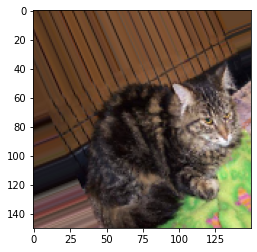

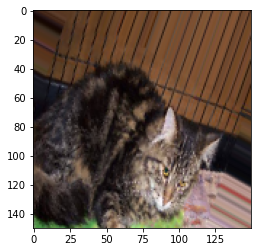

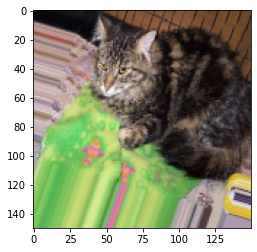

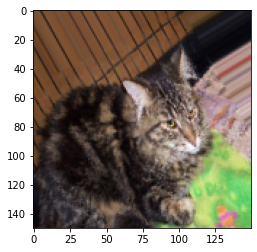

In [7]:
#数据增强
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir,fname) for fname in os.listdir(train_cats_dir)]
img_path = fnames[5]
# 读取图片并调整大小
img = image.load_img(img_path, target_size=(150,150))  
# 转成数组
x = image.img_to_array(img)

# shape转成(1,150,150,3)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):  # 生成随机变换后的图像批量
    plt.figure()   
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break  # 循环是无限，需要在某个时刻终止
        
plt.show()

In [8]:
from tensorflow.keras.applications import Xception
conv_base = Xception(weights='imagenet',
                  include_top=False,    # 是否包括全连接分类器，显然在ImageNet中有上千分类，在我们这里是不需要的
                  input_shape=(150, 150, 3))

83697664/83683744 [==============================] - 17s 0us/step


In [9]:
conv_base.trainable = False

In [2]:
from tensorflow.keras import regularizers
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

NameError: name 'tf' is not defined

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [13]:
checkpoint_save_path="./checkpoint/xception.ckpt"
if os.path.exists(checkpoint_save_path+'.index'):
    print("--------加载模型---------")
    model.load_weights(checkpoint_save_path)
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                              save_weights_only=True,
                                              save_best_only=True)

In [14]:
history=model.fit_generator(
      train_generator,
      steps_per_epoch=94,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=32,
    callbacks=[cp_callback])

D:\programming\Anaconda\envs\tensorflow2\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
94/94 [==============================] - 36s 321ms/step - loss: 0.2408 - acc: 0.8905 - val_loss: 0.0950 - val_acc: 0.9645
Epoch 2/50
94/94 [==============================] - 27s 284ms/step - loss: 0.1586 - acc: 0.9307 - val_loss: 0.0789 - val_acc: 0.9695
Epoch 3/50
94/94 [==============================] - 27s 284ms/step - loss: 0.1509 - acc: 0.9348 - val_loss: 0.0767 - val_acc: 0.9730
Epoch 4/50
94/94 [==============================] - 27s 286ms/step - loss: 0.1403 - acc: 0.9452 - val_loss: 0.0741 - val_acc: 0.9700
Epoch 5/50
94/94 [==============================] - 27s 284ms/step - loss: 0.1279 - acc: 0.9442 - val_loss: 0.0758 - val_acc: 0.9720
Epoch 6/50
94/94 [==============================] - 27s 284ms/step - loss: 0.1330 - acc: 0.9460 - val_loss: 0.0706 - val_acc: 0.9735
Epoch 7/50
94/94 [==============================] - 27s 284ms/step - loss: 0.1266 - acc: 0.9472 - val_loss: 0.0695 - val_acc: 0.9750
Epoch 8/50
94/94 [==============================] - 27s 287ms/step - 

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2

Text(0.5, 1.0, 'Training and validation loss')

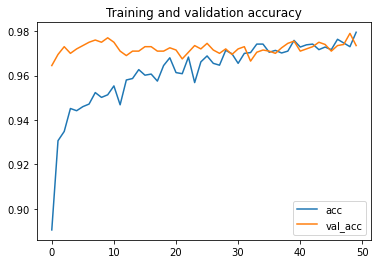

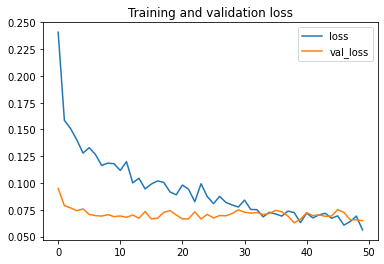

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc))
plt.plot  ( epochs,     acc ,label='acc')
plt.plot  ( epochs, val_acc ,label='val_acc')
plt.legend(loc='best')
plt.title ('Training and validation accuracy')
plt.figure()
plt.plot  ( epochs,     loss ,label='loss')
plt.plot  ( epochs, val_loss ,label='val_loss')
plt.legend(loc='best')
plt.title ('Training and validation loss')

In [17]:
model.save("cats_and_dogs_xception.h5")

D:\programming\Anaconda\envs\tensorflow2\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
